In [ ]:
#!pip install cudaq-solvers==0.3.0 pyqubo==1.5.0 networkx==3.4.2 -q
# Remember to restart the kernel after installing the packages

# **CUDA-Q Solvers**

## QAOA
The **Quantum Approximate Optimization Algorithm (QAOA)** is a variational quantum algorithm designed to solve combinatorial optimization problems. It operates by alternating between two quantum operators:  
1. **Cost Hamiltonian** – Encodes the problem constraints.  
2. **Mixer Hamiltonian** – Introduces transitions between states.  

By optimizing parameters in these operations, QAOA aims to find high-quality approximate solutions to problems like **Max-Cut** and **QUBO** (Quadratic Unconstrained Binary Optimization) on near-term quantum devices. To learn more details, [here](https://github.com/NVIDIA/cuda-q-academic/blob/main/qaoa-for-max-cut/01_Max-Cut-with-QAOA.ipynb) is a well-structured tutorial.

---

## Max-Cut
Let's explore the Max-Cut problem, with its Hamiltonian expressed using Pauli operators as follows:

$$
H = 1/2\sum_{(i, j) \in E} w_{ij}(I-Z_i Z_j)
$$  

where:
- $Z_i$ represents the Pauli-Z operator for qubit (node) $i$.
- Each edge $(i, j)$ contributes a term $w_{ij}(I-Z_i Z_j)/2$,  
- If nodes $i$ and $j$ are assigned to different groups, they contribute a cut of weight $w_{ij}$; otherwise, the contribution is $0$.

First, we define the binary variables and objective based on the graph structure using PyQUBO:

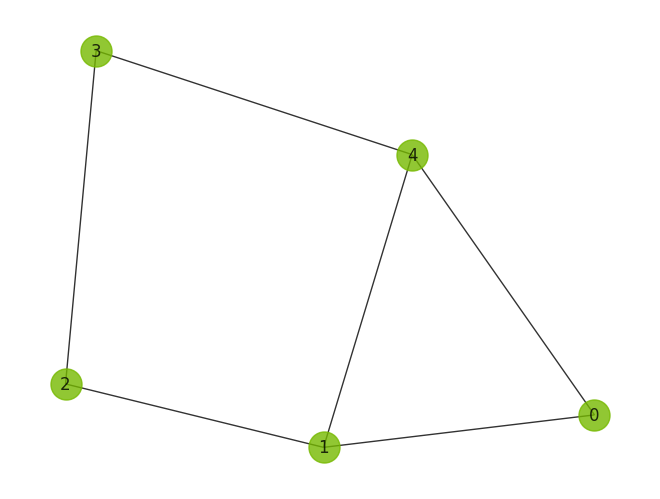

In [2]:
import networkx as nx


# Create weighted graph
G = nx.Graph()
G.add_weighted_edges_from([(0, 1, 1.5), (1, 2, 2.0), (1, 4, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 0, 1.0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500, node_color='#76B900')

In [3]:
from pyqubo import Binary


"""Modify this code block to address other combinatorial optimization problems formulated using PyQUBO"""

# Define binary variables (0, 1) for each node
variables = {i: Binary(f"x_{i}") for i in G.nodes}

# Objective: maximize the sum over cut edges (multiplied by -1 for minimization):
objective = sum((-1)*G[i][j]['weight']*(variables[i] + variables[j] - 2 * variables[i] * variables[j]) for i, j in G.edges)

# Compile model
model = objective.compile()

Note that the QUBO formulation from PyQUBO is based on the 0 and 1 basis. Here, we aim to transform it into the -1 and 1 basis and construct the Hamiltonian with Ising formulation, making it compatible for use with CUDA-Q:

In [4]:
import cudaq
from cudaq import spin
import numpy as np
from typing import List


def to_cudaq(model):
    """
    Convert a binary optimization model to QAOA inputs compatible with CUDA-Q.

    This function extracts the linear and quadratic coefficients from the model's
    Ising formulation, maps variables to qubit indices, and constructs:
      - Number of qubits
      - Flattened coefficient matrix representing both linear (Z) and quadratic (ZZ) terms
      - CUDA-Q Hamiltonian composed of corresponding Pauli Z operators
    """

    num_qubits = len(model.variables)
    h, J, offset = model.to_ising()

    # Map variables to qubit indices
    vars_set = set(h) | {v for pair in J for v in pair}
    var_to_index = {var: idx for idx, var in enumerate(sorted(vars_set))}

    # Initialization
    coeff_matrix = np.zeros((num_qubits, num_qubits), dtype=float)
    H = 0

    # Fill in linear terms (diagonal)
    for var, weight in h.items():
        idx = var_to_index[var]
        coeff_matrix[idx, idx] = float(weight)
        H += weight * spin.z(idx)

    # Fill in quadratic terms (off-diagonal)
    for (v1, v2), weight in J.items():
        i, j = var_to_index[v1], var_to_index[v2]
        coeff_matrix[i, j] = float(weight)
        coeff_matrix[j, i] = float(weight)  # symmetric
        H += weight * spin.z(i) * spin.z(j)

    H += offset
    flattened_coeff = coeff_matrix.flatten()

    return num_qubits, flattened_coeff, H


num_qubits, flattened_coeff, H = to_cudaq(model)
print("Number of qubits:", num_qubits)
print("Flattened coefficient matrix:", flattened_coeff)
print("Hamiltonian:", H)

Number of qubits: 5
Flattened coefficient matrix: [0.   0.75 0.   0.   0.5  0.75 0.   1.   0.   0.5  0.   1.   0.   0.5
 0.   0.   0.   0.5  0.   0.5  0.5  0.5  0.   0.5  0.  ]
Hamiltonian: (-3.75+0i) + (0.5+0i) * Z3Z4 + (0.5+0i) * Z2Z3 + (0.5+0i) * Z1Z4 + (1+0i) * Z1Z2 + (0.5+0i) * Z0Z4 + (0.75+0i) * Z0Z1


The `to_cudaq` function allows for the conversion of any variables and objectives pre-defined by `pyqubo` into CUDA-Q compatible primitives. You can utilize this transformation for other problems you wish to solve.

## **QAOA using [cudaq-solvers.vqe](https://nvidia.github.io/cudaqx/api/solvers/python_api.html#cudaq_solvers.vqe)**

In [5]:
from scipy.optimize import minimize
import numpy as np


# Parameters of QAOA
num_layers = 2
num_params = 2 * num_layers

@cudaq.kernel
def kernel_qaoa(thetas: List[float]):
    """
    QAOA ansatz using a flattened coefficient matrix for linear and quadratic terms.
    """
    qubits = cudaq.qvector(num_qubits)
    h(qubits)

    for layer in range(num_layers):
        gamma = thetas[layer]
        beta = thetas[layer + num_layers]

        # Apply problem unitary
        for idx, coeff in enumerate(flattened_coeff):
            if coeff != 0:
                i = idx // num_qubits  # Row index
                j = idx % num_qubits   # Column index

                if i == j:
                    # Linear term (diagonal)
                    rz(2.0 * coeff * gamma, qubits[i])
                elif i < j:
                    # Quadratic term (off-diagonal)
                    x.ctrl(qubits[i], qubits[j])
                    rz(2.0 * coeff * gamma, qubits[j])
                    x.ctrl(qubits[i], qubits[j])

        # Apply mixer unitary
        for i in range(num_qubits):
            rx(2.0 * beta, qubits[i])



# Specify the initial parameters and visualize the kernel
np.random.seed(42)
initial_parameters = np.random.uniform(-np.pi / 8.0, np.pi / 8.0, num_params)
print("Initial parameters = ", initial_parameters)
print(cudaq.draw(kernel_qaoa, initial_parameters))

Initial parameters =  [-0.09853596  0.35399019  0.18220762  0.07748619]
     ╭───╮                                                   ╭────────────╮»
q0 : ┤ h ├──●───────────────────●────●────────────────────●──┤ rx(0.3644) ├»
     ├───┤╭─┴─╮╭─────────────╮╭─┴─╮  │                    │  ╰────────────╯»
q1 : ┤ h ├┤ x ├┤ rz(-0.1478) ├┤ x ├──┼────────────────────┼────────●───────»
     ├───┤╰───╯╰─────────────╯╰───╯  │                    │      ╭─┴─╮     »
q2 : ┤ h ├───────────────────────────┼────────────────────┼──────┤ x ├─────»
     ├───┤                           │                    │      ╰───╯     »
q3 : ┤ h ├───────────────────────────┼────────────────────┼────────────────»
     ├───┤                         ╭─┴─╮╭──────────────╮╭─┴─╮              »
q4 : ┤ h ├─────────────────────────┤ x ├┤ rz(-0.09854) ├┤ x ├──────────────»
     ╰───╯                         ╰───╯╰──────────────╯╰───╯              »

################################################################################

In [13]:
import cudaq_solvers as solvers
from scipy.optimize import minimize


# Optimize through cudaq-solver
cudaq.set_target('nvidia')  # Simulation on GPU backend
expectation, optimized_parameters, _ = solvers.vqe(kernel_qaoa,
                                              H,
                                              initial_parameters,
                                              optimizer=minimize,
                                              method='L-BFGS-B',
                                              jac='3-point',
                                              tol=1e-5,
                                              options={'disp': True})

print('Final expectation value  =', expectation)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.31663D+00    |proj g|=  5.00569D+00

At iterate    1    f= -4.37282D+00    |proj g|=  2.44248D+00

At iterate    2    f= -4.79023D+00    |proj g|=  1.75523D+00

At iterate    3    f= -5.15228D+00    |proj g|=  1.60731D+00

At iterate    4    f= -5.30906D+00    |proj g|=  1.61277D+00

At iterate    5    f= -5.40131D+00    |proj g|=  5.57339D-01

At iterate    6    f= -5.46033D+00    |proj g|=  8.58986D-01

At iterate    7    f= -5.52316D+00    |proj g|=  8.45318D-01

At iterate    8    f= -5.72155D+00    |proj g|=  1.64532D+00

At iterate    9    f= -5.81155D+00    |proj g|=  1.03733D+00

At iterate   10    f= -5.87986D+00    |proj g|=  5.83329D-01

At iterate   11    f= -5.88656D+00    |proj g|=  3.38301D-01

At iterate   12    f= -5.88690D+00    |proj g|=  2.68276D-01

At iterate   13    f= -5.8

In [15]:
def to_variables(variables, kernel_qaoa, optimized_parameters, method="statevector"):
    """
    Return the result in the format of the predefined binary variables.
    """

    if method == "sampling":
        # Sample the circuit and find the most probable bitstring
        counts = cudaq.sample(kernel_qaoa, optimized_parameters, shots_count=8192)
        most_probable_bits = counts.most_probable()

    if method == "statevector":
        # Compute the state vector and extract the most probable bitstring
        states = cudaq.get_state(kernel_qaoa, optimized_parameters)
        bits = [f"{format(i, f'0{states.num_qubits()}b')}" for i in range(2**states.num_qubits())]
        probs = np.abs(states.amplitudes([f"{b}" for b in bits]))**2
        most_probable_bits = bits[np.argmax(probs)]

    best_result = {str(variables[i]): int(bit) for i, bit in enumerate(most_probable_bits)}

    return best_result


best_result = to_variables(variables, kernel_qaoa, optimized_parameters, method="statevector")
print("Best result:", best_result)

Best result: {"Binary('x_0')": 0, "Binary('x_1')": 1, "Binary('x_2')": 0, "Binary('x_3')": 1, "Binary('x_4')": 0}


## **QAOA using cudaq-solvers.qaoa**
Use a simpler and more intuitive approach with the built-in `cudaq-solvers.qaoa` API.

In [17]:
import cudaq_solvers as solvers


# Get the number of parameters we'll need
num_layers = 2
parameter_count = solvers.get_num_qaoa_parameters(H,
                                                  num_layers,
                                                  full_parameterization=True)

# Create the initial parameters to begin optimization
initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8, parameter_count)

# Set up the optimizer for convergence; supported cudaq-x optimizers include 'cobyla' and 'lbfgs'
optimizer = 'cobyla'

# Run QAOA, specify full parameterization using an optimization parameter for
# every term in the problem Hamiltonian and the mixer hamiltonian.
opt_value, opt_params, opt_config = solvers.qaoa(H,
                                                 num_layers,
                                                 initial_parameters,
                                                 optimizer=optimizer,
                                                 full_parameterization=True,
                                                 )

# Print the results
print('Optimal energy: ', opt_value)
print('Sampled states: ', opt_config)
print('Optimal Configuration: ', opt_config.most_probable())

Optimal energy:  -6.499508000027675
Sampled states:  { 01010:533 10101:467 }

Optimal Configuration:  01010
